<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [1240]:
import matplotlib.pyplot as plt

% matplotlib inline

In [1241]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [1242]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column


In [1243]:
data = pd.concat([X,y], axis=1)
data.head()
#data = data.sample(frac=1) #https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [1244]:
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [1245]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


In [1246]:
data.shape

(506, 14)

In [1247]:
data.CHAS.dtype
data.CHAS = data.CHAS.astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null category
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: category(1), float64(13)
memory usage: 52.1 KB


In [1248]:
data.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [1249]:
data.nunique()

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
MEDV       229
dtype: int64

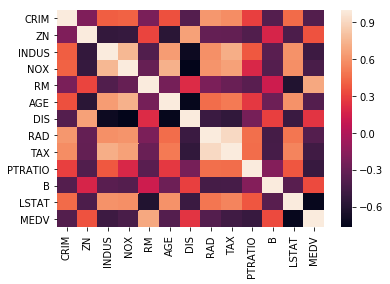

In [1250]:
import seaborn as sns
sns.heatmap(data.corr())

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

[36.22453282]
[[-0.03721193 -9.28614359 -0.01319241 -0.16787814]]


[('AGE', array([-0.03721193, -9.28614359, -0.01319241, -0.16787814]))]

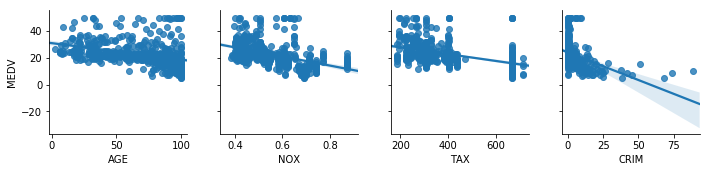

In [1251]:
from sklearn.linear_model import LinearRegression
feature_col=['AGE', 'NOX', 'TAX', 'CRIM'] #these 4 features have little correlation from the scatterplot
sns.pairplot(data, x_vars=feature_col, y_vars='MEDV', kind='reg')
X_sub = data[feature_col]
lr = LinearRegression()
type(lr)
lr
lr.fit(X_sub, y)

print(lr.intercept_)
print(lr.coef_)

list(zip(feature_col, lr.coef_))

In [1252]:
pred = lr.predict(X_sub)
true = y

In [1253]:
from sklearn import metrics #http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
print('MAE:', metrics.mean_absolute_error(true, pred))
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 5.61948178883166
MSE: 61.901299060061326
RMSE: 7.8677378616767175


### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

#### 70/30 train/test split

In [1254]:
from sklearn.model_selection import train_test_split
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y, test_size=0.3, random_state=1)
print(X_sub_train.shape, y_sub_train.shape)
print(X_sub_test.shape, y_sub_test.shape)

(354, 4) (354, 1)
(152, 4) (152, 1)


In [1255]:
lr = LinearRegression()
lr.fit(X_sub_train, y_sub_train)
pred = lr.predict(X_sub_test)
true = y_sub_test

In [1256]:
print('MAE:', metrics.mean_absolute_error(true, pred))
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 5.925674610373759
MSE: 72.05580151439725
RMSE: 8.488568873160967


#### 90/10 train/test split

In [1257]:
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.1, random_state=1)
print(X_sub_train.shape, y_sub_train.shape)
print(X_sub_test.shape, y_sub_test.shape)

(455, 4) (455,)
(51, 4) (51,)


In [1258]:
lr = LinearRegression()
lr.fit(X_sub_train, y_sub_train)
pred = lr.predict(X_sub_test)
true = y_sub_test

In [1259]:
print('MAE:', metrics.mean_absolute_error(true, pred))
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 5.694538207883084
MSE: 58.94629593434768
RMSE: 7.677649115083841


### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

#### test code

In [1260]:
#from sklearn.model_selection import KFold
#kf = KFold(n_splits=5, random_state=123)
#kf.get_n_splits(X_sub)
#print(kf)

In [1261]:
#for train_index, test_index in kf.split(X_sub):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X_sub.iloc[train_index], X_sub.iloc[test_index]
    #y_train, y_test = y_sub.iloc[train_index], y_sub.iloc[test_index]

In [1262]:
#********************Types of scoring/assessment metrics in cross_val_score****************
# http://scikit-learn.org/stable/modules/model_evaluation.html
# https://www.ritchieng.com/machine-learning-cross-validation/ 
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html 

#### cv = 5

In [1263]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import numpy as np
lr = LinearRegression()

#Calculating Mean Abs Error (MAE) #http://scikit-learn.org/stable/modules/model_evaluation.html
scores = cross_val_score(lr, X_sub, y_sub, cv=5, scoring='neg_mean_absolute_error')
print(-scores)
print(-scores.mean())

[6.24384575 8.04933826 6.82448607 5.46644046 7.11037078]
6.738896264463743


In [1264]:
#Calculating Mean Squared Error (MSE)
scores = cross_val_score(lr, X_sub, y_sub, cv=5, scoring='neg_mean_squared_error')
print(-scores)
print(-scores.mean())

[ 70.73712759 129.36163451  78.0655316   51.37044623 102.54267262]
86.4154825108114


In [1265]:
#Calculating Root Mean Square Error (RMSE)
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
print(rmse_scores)
print(rmse_scores.mean())

[ 8.4105367  11.37372562  8.83547008  7.16731792 10.1263356 ]
9.182677185395018


#### cv=10 - errors are similar (not smaller) compared to cv=5

In [1266]:
#Calculating Mean Abs Error (MAE)
scores = cross_val_score(lr, X_sub, y_sub, cv=10, scoring='neg_mean_absolute_error')
print(-scores)
print(-scores.mean())

[7.07636577 5.37641933 7.9129463  8.21138477 6.24012627 7.11964502
 5.61978493 5.48118226 7.21089829 7.14282492]
6.7391577852586195


In [1267]:
#Calculating Mean Squared Error (MSE)
scores = cross_val_score(lr, X_sub, y_sub, cv=10, scoring='neg_mean_squared_error')
print(-scores)
print(-scores.mean())

[ 87.72852661  55.4681161  132.52062318 123.61128793  76.34720169
  78.24530286  50.32970429  54.17399991 114.33927613  93.16311301]
86.59271517169421


In [1268]:
#Calculating Root Mean Square Error (RMSE)
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
print(rmse_scores)
print(rmse_scores.mean())

[ 9.36635076  7.447692   11.51176021 11.11806134  8.73768858  8.8456375
  7.09434312  7.3602989  10.69295451  9.65210407]
9.182689099516134


# KNN Practice

In [1269]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [1270]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [1271]:
# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [1272]:
# Create a custom colormap
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [1273]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'

species_mapping={'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}
species_code = np.array(iris['species'].map(species_mapping))
species_code = pd.Series(species_code)
iris_new = pd.concat([iris, species_code], axis=1)
iris_new.head()
iris_new.columns.values[5] = 'species_code'  #https://stackoverflow.com/questions/38101009/changing-multiple-column-names-but-not-all-of-them-panda-python

#check if the mapping has took place properly
iris_new.head()
iris_new.groupby('species_code').species.value_counts()

species_code  species        
0             Iris-setosa        50
1             Iris-versicolor    50
2             Iris-virginica     50
Name: species, dtype: int64

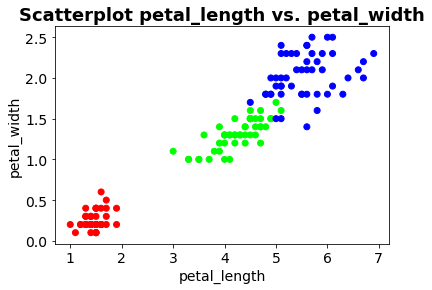

In [1274]:
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES

iris.columns

#https://matplotlib.org/users/text_intro.html ---- adjusting parameters for the scatterplot
plt.scatter(iris.petal_length,iris.petal_width, c=species_code, cmap=cmap_bold) #https://stackoverflow.com/questions/12487060/matplotlib-color-according-to-class-labels
plt.title('Scatterplot petal_length vs. petal_width', fontweight='bold', fontsize=18)
plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.show()

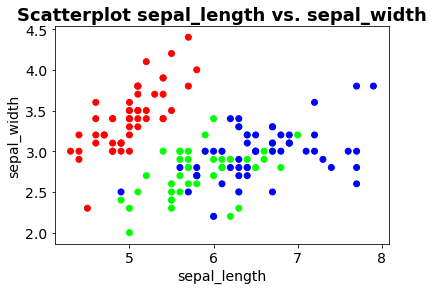

In [1275]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES

iris.columns

#https://matplotlib.org/users/text_intro.html ---- adjusting parameters for the scatterplot
plt.scatter(iris.sepal_length,iris.sepal_width, c=species_code, cmap=cmap_bold)
plt.title('Scatterplot sepal_length vs. sepal_width', fontweight='bold', fontsize=18)
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.show()

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [1276]:
iris_new.shape

(150, 6)

In [1277]:
iris_final = iris_new.drop(['species'], axis=1) # https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
iris_final.head()

,sepal_length,sepal_width,petal_length,petal_width,species_code
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [1278]:
X = iris_final.iloc[:,0:4]
X.shape

(150, 4)

### Create your target vector "y"
This will be the species type.

In [1279]:
y = iris_final.iloc[:,-1]
y.shape

# https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe
# Count_Row=df.shape[0] #gives number of row count
# Count_Col=df.shape[1] #gives number of col count

(150,)

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [1280]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [1281]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [1282]:
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.9111111111111111


### Create a Model With Five Neighbors. Did it Improve?

In [1283]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.9777777777777777


### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [1284]:
X_train.shape[0]
type(X_train.shape[0])

for i in range(1,(X_train.shape[0]+1)):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred_class = knn.predict(X_test)
    print("K="+ str(i)+ " " +"accuracy: " + str(round(metrics.accuracy_score(y_test, y_pred_class),3)))

K=1 accuracy: 0.911
K=2 accuracy: 0.911
K=3 accuracy: 0.956
K=4 accuracy: 0.956
K=5 accuracy: 0.978
K=6 accuracy: 0.956
K=7 accuracy: 0.978
K=8 accuracy: 0.956
K=9 accuracy: 0.956
K=10 accuracy: 0.956
K=11 accuracy: 0.978
K=12 accuracy: 0.978
K=13 accuracy: 0.978
K=14 accuracy: 0.956
K=15 accuracy: 0.978
K=16 accuracy: 0.956
K=17 accuracy: 0.956
K=18 accuracy: 0.889
K=19 accuracy: 0.911
K=20 accuracy: 0.911
K=21 accuracy: 0.911
K=22 accuracy: 0.889
K=23 accuracy: 0.889
K=24 accuracy: 0.889
K=25 accuracy: 0.911
K=26 accuracy: 0.889
K=27 accuracy: 0.911
K=28 accuracy: 0.889
K=29 accuracy: 0.911
K=30 accuracy: 0.911
K=31 accuracy: 0.911
K=32 accuracy: 0.889
K=33 accuracy: 0.889
K=34 accuracy: 0.867
K=35 accuracy: 0.867
K=36 accuracy: 0.867
K=37 accuracy: 0.867
K=38 accuracy: 0.867
K=39 accuracy: 0.867
K=40 accuracy: 0.867
K=41 accuracy: 0.867
K=42 accuracy: 0.867
K=43 accuracy: 0.867
K=44 accuracy: 0.867
K=45 accuracy: 0.867
K=46 accuracy: 0.867
K=47 accuracy: 0.867
K=48 accuracy: 0.867
K

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

In [1285]:
#from above
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.9777777777777777


In [1286]:
# Returns the probablity of the 3 classes -- '0', '1' or '2'
knn.predict_proba(X_test)

array([[0. , 0.4, 0.6],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.4, 0.6],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.8, 0.2],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.4, 0.6],
       [1. , 0. , 0. ],
       [0. , 0.4, 0.6],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.2, 0.8],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0.4, 0.6],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. 

In [1287]:
# The class with the highest probability of happening will be indicated as the predicted class for that row
y_pred_class

array([2, 2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 2,
       0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2,
       2])

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [1288]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target

In [1289]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [1290]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1220.
Date:                Wed, 27 Jun 2018   Prob (F-statistic):          1.59e-321
Time:                        05:52:18   Log-Likelihood:                -1567.7
No. Observations:                 506   AIC:                             3151.
Df Residuals:                     498   BIC:                             3185.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9744      0.224     22.197      0.000       4.534       5.415
LSTAT         -0.5615      0.048    -11.817      0.000      -0.655      -0.468
RAD            0.2109      0.070      3.025      0.003       0.074       0.348
TAX           -0.0174      0.004     -4.267      0.000      -0.025      -0.009
NOX            4.3456      3.385      1.284      0.200      -2.305      10.997
INDUS          0.0925      0.067      1.385      0.167      -0.039       0.224
CRIM          -0.0866      0.037     -2.362      0.019      -0.159      -0.015
ZN             0.0288      0.013      2.215      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.072   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              831.634
Skew:                           1.665   Prob(JB):                    2.59e-181
Kurtosis:                       8.325   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

In [1291]:
df.info()
df.shape
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [1292]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [1293]:
#from sklearn.preprocessing import Imputer
#imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
#df_imputed = imr.fit_transform(df.values)
#df_imputed1 = pd.DataFrame(df_imputed)
#df_imputed1.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
#df_imputed1.isnull().sum()

In [1294]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df1 = sc.fit_transform(df_imputed1)
df1 = pd.DataFrame(df1)
df1.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df1.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.417713,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,0.159686
1,-0.415269,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,-0.101524
2,-0.415272,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,1.324247
3,-0.414680,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,1.182758
4,-0.410409,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,1.487503


In [1295]:
X = df1.drop('MEDV', axis=1)
y = df1.iloc[:,-1]

In [1296]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [1297]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

lm = LinearRegression()
lm_lasso = Lasso(alpha=0.1)
lm_ridge = Ridge(alpha=0.1)
lm_elasticnet = ElasticNet(alpha=0.1)

lm.fit(X_train, y_train)
lm_lasso.fit(X_train, y_train)
lm_ridge.fit(X_train, y_train)
lm_elasticnet.fit(X_train, y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

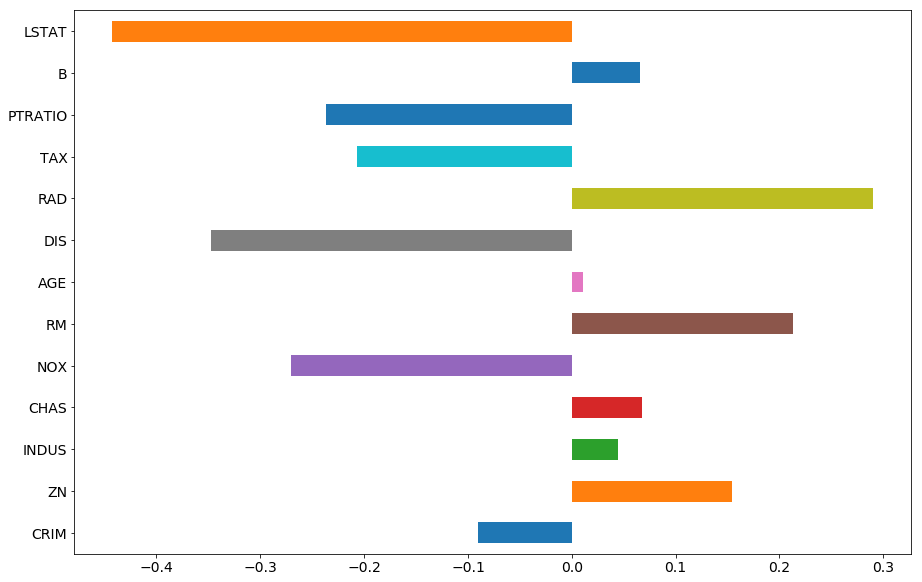

In [1298]:
plt.figure(figsize=(15,10))
ft_importances_lm=pd.Series(lm.coef_, index=X_train.columns)
ft_importances_lm.plot(kind='barh')
plt.show()

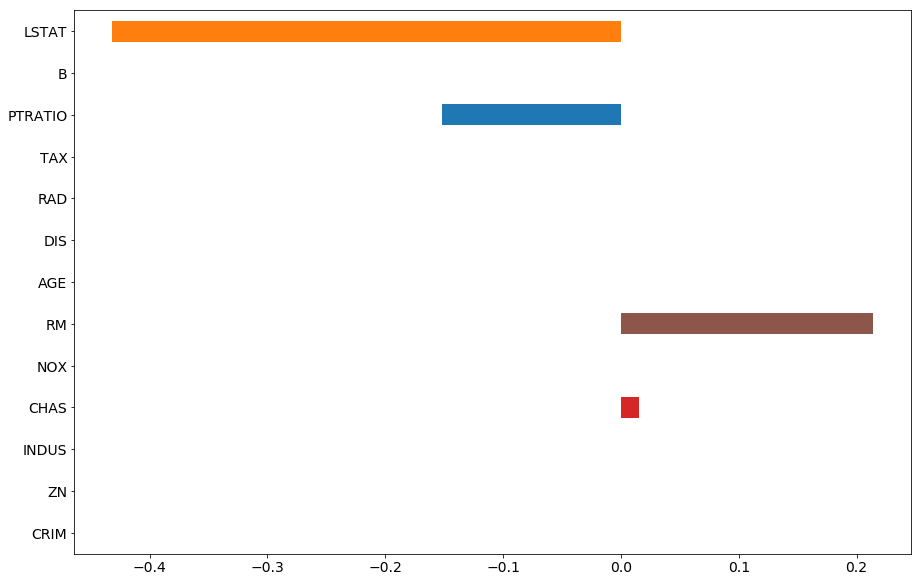

In [1299]:
plt.figure(figsize=(15,10))
ft_importances_lm_lasso=pd.Series(lm_lasso.coef_, index=X_train.columns)
ft_importances_lm_lasso.plot(kind='barh')
plt.show()

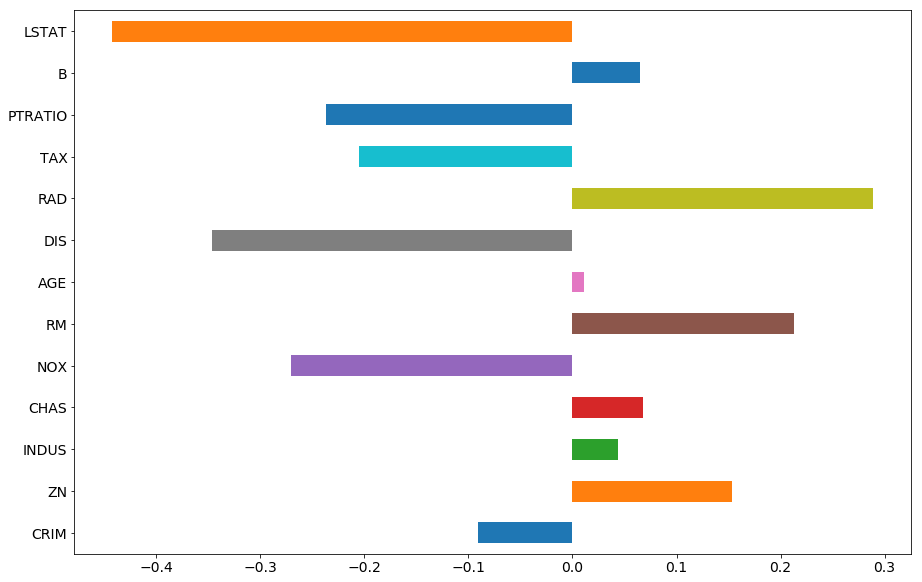

In [1300]:
plt.figure(figsize=(15,10))
ft_importances_lm_ridge=pd.Series(lm_ridge.coef_, index=X_train.columns)
ft_importances_lm_ridge.plot(kind='barh')
plt.show()

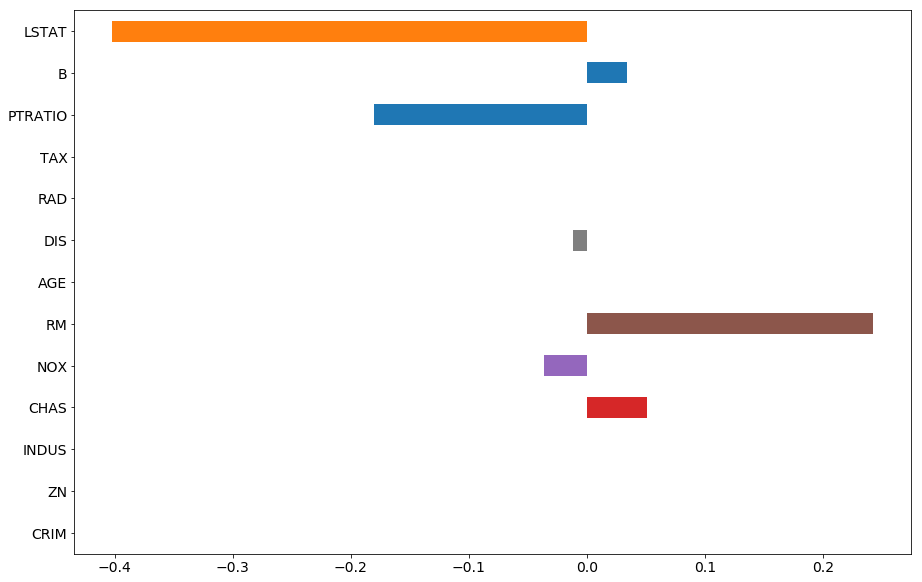

In [1301]:
plt.figure(figsize=(15,10))
ft_importances_lm_elasticnet=pd.Series(lm_elasticnet.coef_, index=X.columns)
ft_importances_lm_elasticnet.plot(kind='barh')
plt.show()

In [1302]:
model = smf.ols("MEDV ~ RAD + DIS + INDUS + ZN - 1", data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     498.5
Date:                Wed, 27 Jun 2018   Prob (F-statistic):          3.01e-173
Time:                        05:52:20   Log-Likelihood:                -1927.3
No. Observations:                 506   AIC:                             3863.
Df Residuals:                     502   BIC:                             3880.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RAD           -0.0209      0.070     -0.300      0.765      -0.158       0.116
DIS            3.4677      0.202     17.202      0.000       3.072       3.864
INDUS          0.6403      0.077      8.336      0.000       0.489       0.791
ZN             0.0673      0.028      2.396      0.017       0.012       0.123
==============================================================================
Omnibus:                      100.511   Durbin-Watson:                   0.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.388
Skew:                           1.169   Prob(JB):                     8.22e-39
Kurtosis:                       4.689   Cond. No.                         11.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1323]:
train=pd.concat([X_train,y_train], axis=1)
test=pd.concat([X_test,y_test], axis=1)

model = smf.ols("MEDV ~ RAD + DIS + INDUS + ZN - 1", data=train)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     19.13
Date:                Wed, 27 Jun 2018   Prob (F-statistic):           1.23e-13
Time:                        06:08:58   Log-Likelihood:                -292.01
No. Observations:                 239   AIC:                             592.0
Df Residuals:                     235   BIC:                             605.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RAD           -0.1637      0.066     -2.490      0.013      -0.293      -0.034
DIS           -0.2759      0.089     -3.117      0.002      -0.450      -0.101
INDUS         -0.4066      0.083     -4.888      0.000      -0.571      -0.243
ZN             0.2424      0.080      3.048      0.003       0.086       0.399
==============================================================================
Omnibus:                      106.763   Durbin-Watson:                   1.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              395.094
Skew:                           1.888   Prob(JB):                     1.61e-86
Kurtosis:                       8.042   Cond. No.                         3.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1322]:
X4 = X[['RAD', 'DIS', 'INDUS', 'ZN']]
from sklearn.model_selection import train_test_split
X4_train, X4_test, y_train, y_test = train_test_split(X4, y, test_size=0.3, random_state=2)

lm = LinearRegression()
lm.fit(X4_train,y_train)
pred = lm.predict(X4_test)
true = y_test

print("r2_score: " + str(metrics.r2_score(true, pred)))
print("MAE_score: " + str(metrics.mean_absolute_error(true, pred)))
print("MSE_score: " + str(metrics.mean_squared_error(true, pred)))
print("RMSE_score: " + str(np.sqrt(metrics.mean_squared_error(true, pred))))

r2_score: 0.39548519556734796
MAE_score: 0.5913953876797424
MSE_score: 0.6179494146864896
RMSE_score: 0.7860975859818484


In [1321]:
X4_train, X4_test, y_train, y_test = train_test_split(X4, y, test_size=0.1, random_state=2)
lm = LinearRegression()
lm.fit(X4_train,y_train)
pred = lm.predict(X4_test)
true = y_test

print("r2_score: " + str(metrics.r2_score(true, pred)))
print("MAE_score: " + str(metrics.mean_absolute_error(true, pred)))
print("MSE_score: " + str(metrics.mean_squared_error(true, pred)))
print("RMSE_score: " + str(np.sqrt(metrics.mean_squared_error(true, pred))))

r2_score: 0.42189026242322725
MAE_score: 0.498312150703959
MSE_score: 0.5047327510931836
RMSE_score: 0.7104454596189518


In [1342]:
scores = cross_val_score(lm, X4, y, cv=5, scoring='r2')
scores = -1*scores
print("r2_score: " + str(scores))
print("mean r2_score: " + str(scores.mean()))

scores = cross_val_score(lm, X4, y, cv=5, scoring='neg_mean_absolute_error')
scores = -1*scores
print("MAE_score: " + str(scores))
print("mean MAE_score: " + str(scores.mean()))

scores = cross_val_score(lm, X4, y, cv=5, scoring='neg_mean_squared_error')
scores = -1*scores
print("MSE_score: " + str(scores))
print("mean MSE_score: " + str(scores.mean()))

print("RMSE_score: " + str(np.sqrt(scores)))
print("mean RMSE_score: " + str(np.sqrt(scores).mean()))

r2_score: [ 0.08214422 -0.09919436  0.11936956 -0.041862    0.33715098]
mean r2_score: 0.07952168106917748
MAE_score: [0.53938874 0.65954549 0.74297873 0.69517074 0.54809654]
mean MAE_score: 0.6370360480744868
MSE_score: [0.44269437 0.97141498 1.06192429 0.99550462 0.42114168]
mean MSE_score: 0.7785359873744311
RMSE_score: [0.66535281 0.98560386 1.03049711 0.99774978 0.6489543 ]
mean RMSE_score: 0.8656315727021118


In [1343]:
scores = cross_val_score(lm, X4, y, cv=10, scoring='r2')
scores = -1*scores
print("r2_score: " + str(scores))
print("mean r2_score: " + str(scores.mean()))

scores = cross_val_score(lm, X4, y, cv=5, scoring='neg_mean_absolute_error')
scores = -1*scores
print("MAE_score: " + str(scores))
print("mean MAE_score: " + str(scores.mean()))

scores = cross_val_score(lm, X4, y, cv=5, scoring='neg_mean_squared_error')
scores = -1*scores
print("MSE_score: " + str(scores))
print("mean MSE_score: " + str(scores.mean()))

print("RMSE_score: " + str(np.sqrt(scores)))
print("mean RMSE_score: " + str(np.sqrt(scores).mean()))

r2_score: [ 3.31593138e-01  3.45235091e-02  3.61894508e+00  3.60966528e-01
  1.55167949e-01 -2.94061938e-03  4.38917711e-01 -4.18193968e-03
  1.42530839e+00  1.33870082e+00]
mean r2_score: 0.769700056756545
MAE_score: [0.53938874 0.65954549 0.74297873 0.69517074 0.54809654]
mean MAE_score: 0.6370360480744868
MSE_score: [0.44269437 0.97141498 1.06192429 0.99550462 0.42114168]
mean MSE_score: 0.7785359873744311
RMSE_score: [0.66535281 0.98560386 1.03049711 0.99774978 0.6489543 ]
mean RMSE_score: 0.8656315727021118


### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

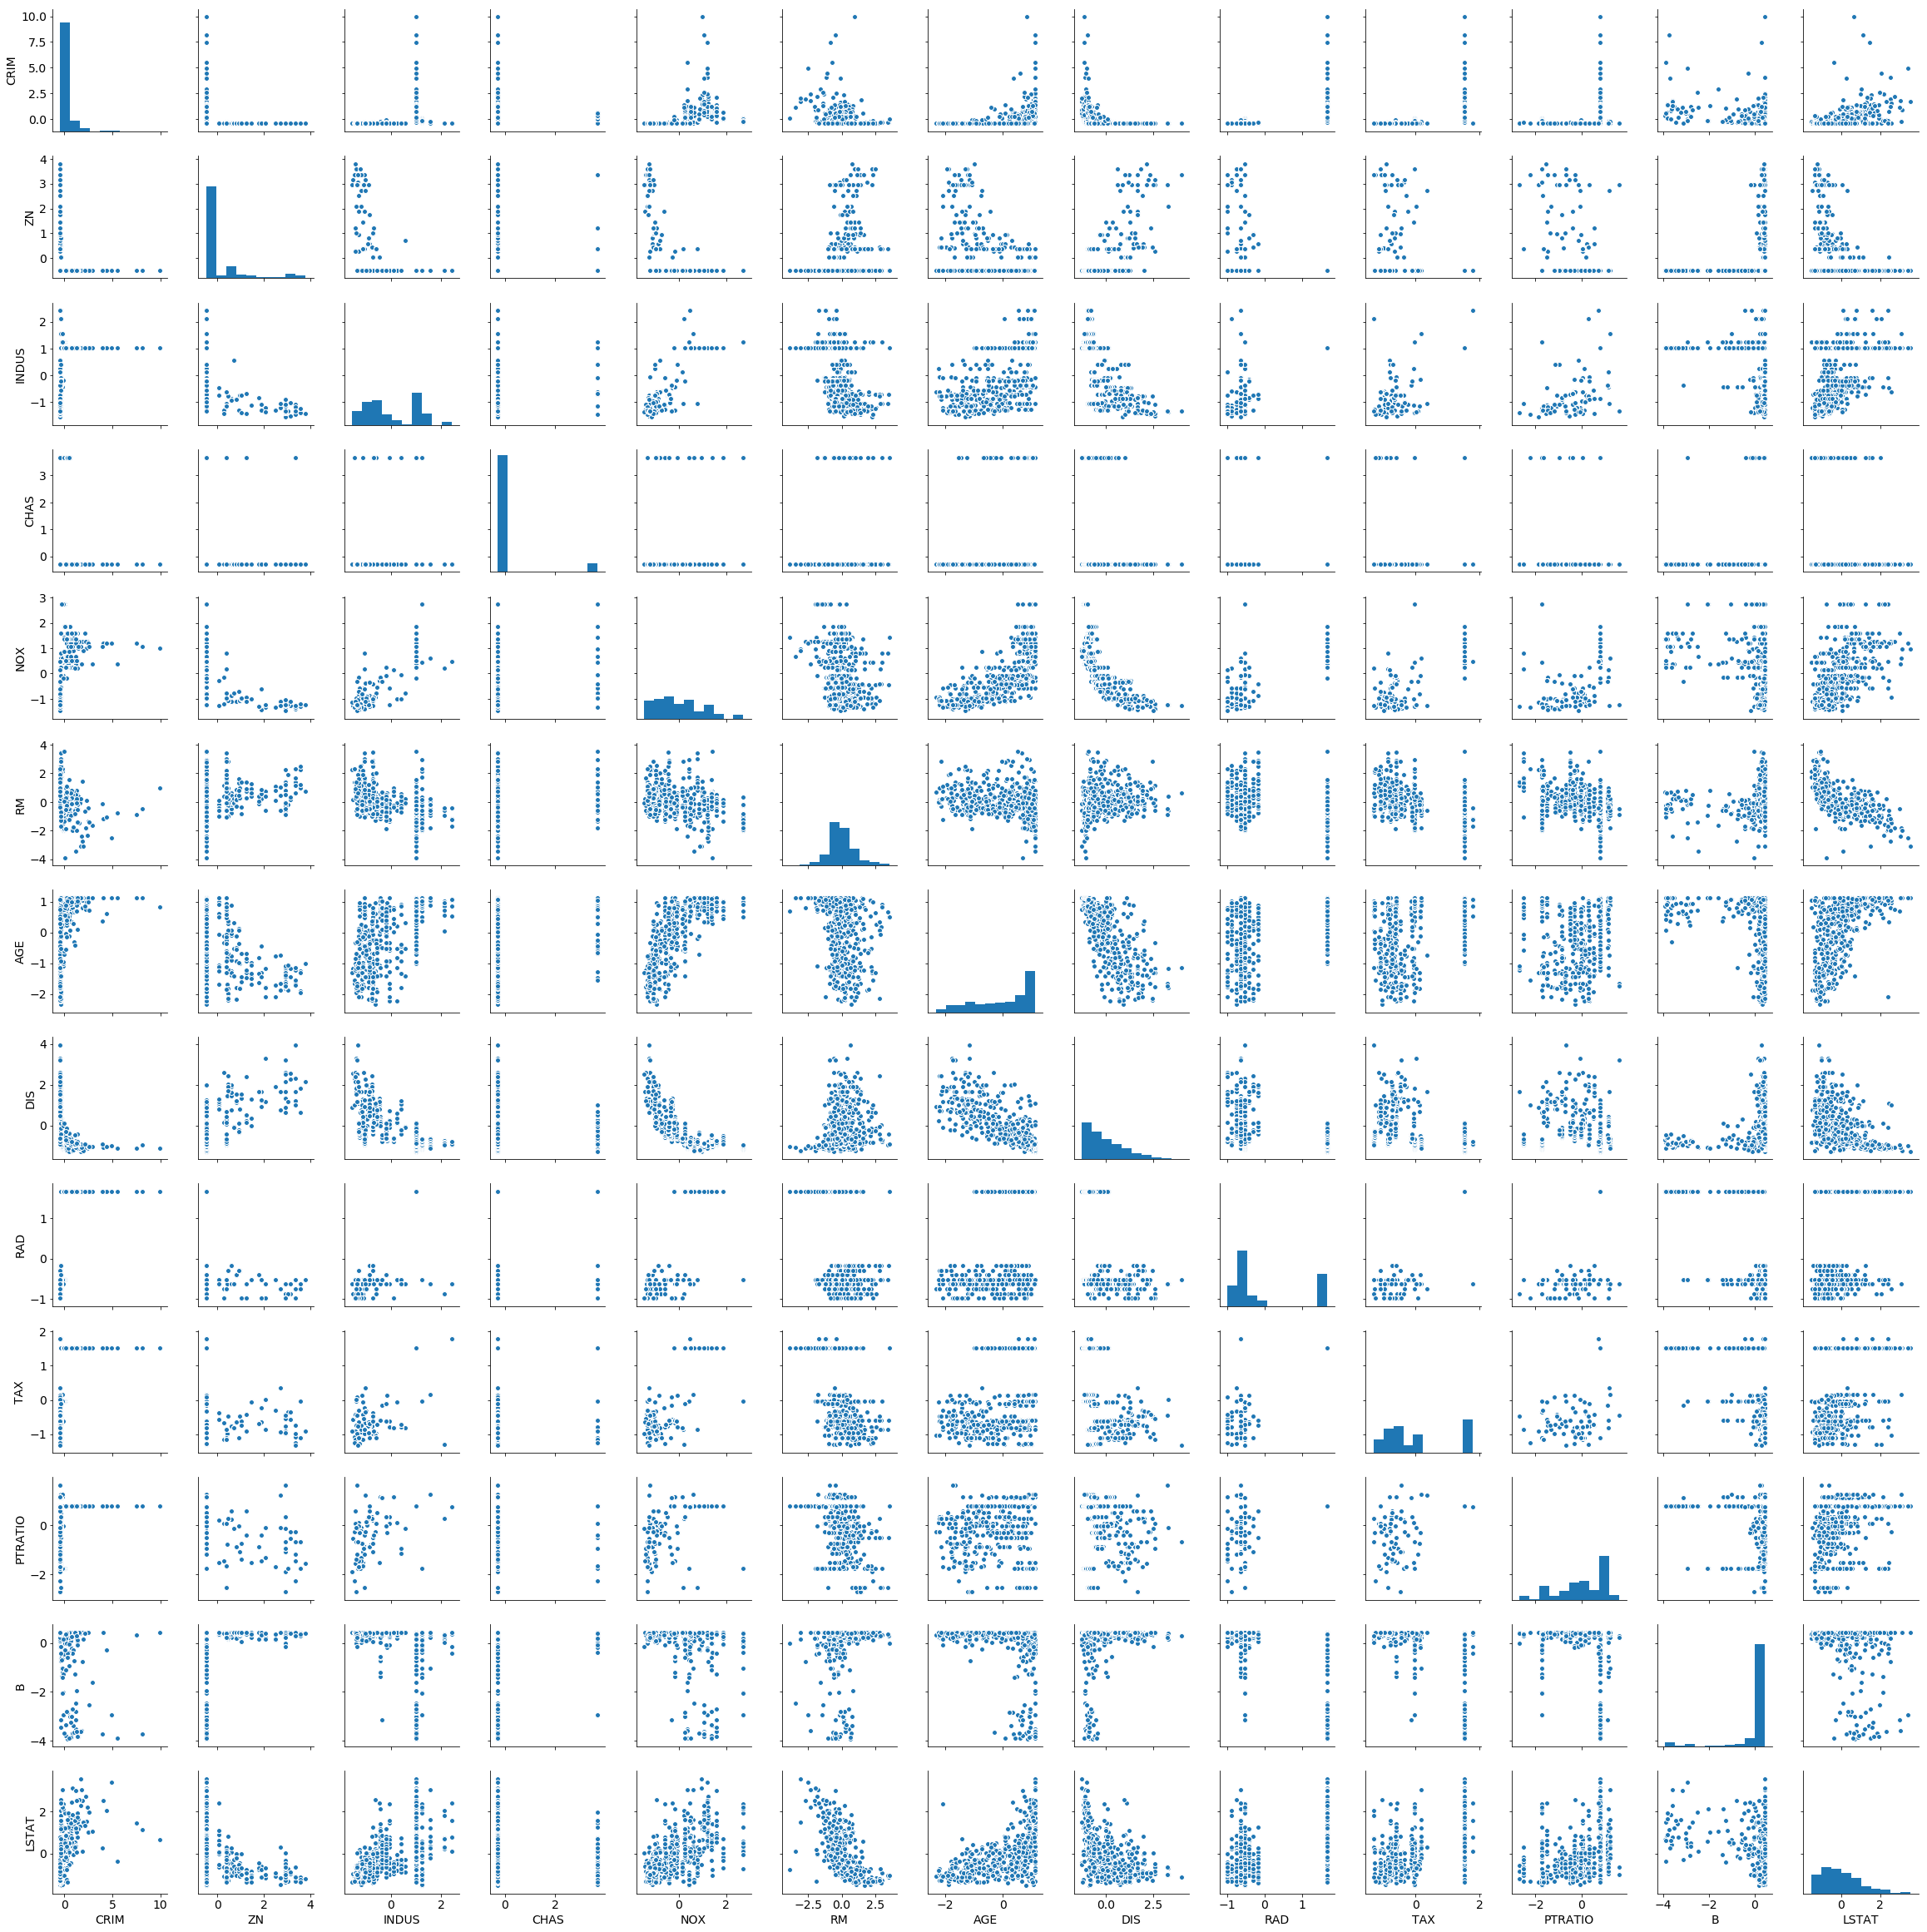

In [1233]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X)

In [1234]:
# Check out Pearson scores
X.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.199458,0.404471,-0.055295,0.417521,-0.219940,0.350784,-0.377904,0.622029,0.579564,0.288250,-0.377365,0.452220
ZN,-0.199458,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.404471,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055295,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.417521,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219940,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.350784,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.377904,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.622029,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.579564,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


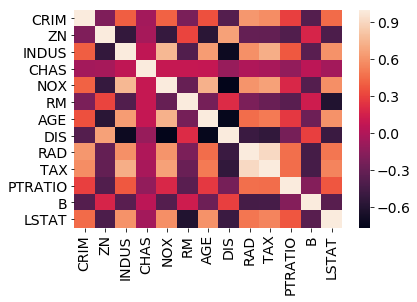

In [1235]:
sns.heatmap(X.corr())

## Demo: Patsy

In [1236]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [1237]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


/Users/tanhongyue/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [1238]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: 0.5180718924319663
